In [1]:
# ! pip install -e ../../savo

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
from copy import deepcopy as copy
from scipy import optimize

import sys
sys.path.append('../')
from savo import savo

In [3]:
ndim = 50
latent_ndim = 2
budget = 200
ninit = 25  # number of initial ES steps to collect data for surrogate model training
noise = 0.0

max_dx = 0.01
lr = 1e-2

In [4]:
decision_CSETs=['X'+str(i) for i in range(ndim)]
decision_min = -1
decision_max =  1
x_bounds = np.array([(decision_min,decision_max)]*ndim)

# obj_func

: rastirigin over 2D latent space of random NN for both high-dim and visualization

In [5]:
import torch
layers = [
    torch.nn.Linear(ndim, 256),torch.nn.ELU(),
    torch.nn.Linear( 256, 256),torch.nn.ELU(),
    torch.nn.Linear( 256,   2)
    ]

torch.nn.init.kaiming_normal_(layers[0].weight, nonlinearity='relu')
torch.nn.init.kaiming_normal_(layers[2].weight, nonlinearity='relu')
torch.nn.init.kaiming_normal_(layers[4].weight, nonlinearity='relu')
with torch.no_grad():
    layers[0].bias.uniform_(-0.1, 0.1)
    layers[2].bias.uniform_(-0.1, 0.1)
#     layers[4].bias.uniform_(-0.1, 0.1)
_compressor_torch = torch.nn.Sequential(*layers)

def compressor(x,ndim=ndim):
    x = torch.tensor(x.reshape(-1,ndim)).to(torch.float32)
    with torch.no_grad():
        z = _compressor_torch(x)
    return z.detach().numpy()


# x = np.random.randn(1024*64,ndim);
x = np.random.rand(1024*64,ndim)*(decision_max-decision_min) + decision_min
y = compressor(x);
y.mean(), y.std()

(0.06156922, 0.94827056)

### find initial x0 for given z0

In [6]:
z0 = 0.5*torch.ones(2)
def loss(x0):
    return torch.mean((_compressor_torch(x0) - z0[None,:])**2,axis=1)

x0 = torch.rand(1024, ndim, requires_grad=True)  # Initial values for optimization
optimizer = torch.optim.Adam([x0], lr=2e-3)
# Optimization loop
num_epochs = 500  # Number of optimization iterations
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Clear previous gradients
    loss_value = loss(x0).sum()  # Compute loss
    loss_value.backward()  # Backpropagate
    optimizer.step()  # Update parameters  
    with torch.no_grad():
        x0.clamp_(min=decision_min, max=decision_max)
        
losses = loss(x0)
x0 = x0[torch.argmin(losses)].detach().numpy()
z0 = compressor(x0)[0]
z0

array([0.5000001, 0.5      ], dtype=float32)

In [7]:
def rastrigin(x,noise=noise):
    if x.ndim == 1:
        return np.sum(x**2 - np.cos(2*np.pi*x))/len(x)+1
    else:
        b,d = x.shape
        y = np.sum(x**2 - np.cos(2*np.pi*x),axis=1)/d +1
        if d==1:
            return float(y) + np.random.randn()*noise
        else:
            return y + np.random.randn(b)*noise

(-1.0, 1.0)

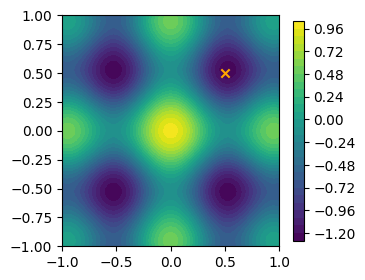

In [8]:
x = np.random.rand(1024*128,2)*(decision_max-decision_min)*1.2 + decision_min*1.2
y = 1-rastrigin(x)

fig, ax = plt.subplots(figsize=(3.5,3))
cs = ax.tricontourf(x[:,0],x[:,1],y, levels=32, cmap="viridis");
fig.colorbar(cs,ax=ax,shrink=0.95);

ax.scatter(z0[0],z0[1],c='orange',marker='x')
ax.set_xlim(decision_min,decision_max)
ax.set_ylim(decision_min,decision_max)

In [9]:
class const_obj_func:
    def __init__(self,minimize=False):
        self.history = {'z':[],'y':[]}
        self.minimize = minimize
    def __call__(self,x):
        z = compressor(x)[0]
        y = 1-rastrigin(z) 
        self.history['z'].append(z)
        self.history['y'].append(y)
        if self.minimize:
            return -y
        else:
            return y

# Nelder-Mead

In [10]:
def make_initial_simplex(x0, step_size=0.01):
    x0 = np.asarray(x0)
    n = len(x0)
    simplex = np.zeros((n + 1, n))
    simplex[0] = x0  # The first vertex is x0

    for i in range(n):
        vertex = x0.copy()
        vertex[i] += step_size  # Modify one dimension at a time
        simplex[i + 1] = vertex
    
    return simplex

In [11]:
obj_func = const_obj_func(minimize=True)
initial_simplex = make_initial_simplex(x0, step_size=max_dx)
result = optimize.minimize(obj_func,x0,method='Nelder-Mead',bounds=x_bounds,
                           options={'adaptive':True,'maxfev':budget,'initial_simplex':initial_simplex})

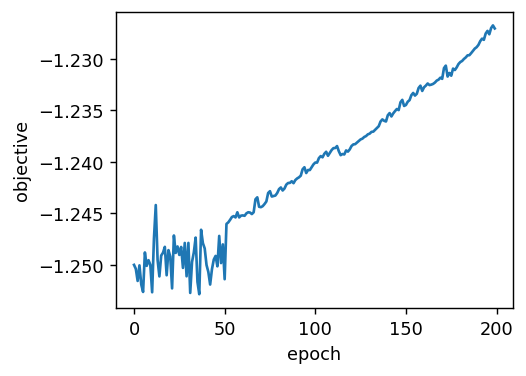

In [12]:
fig, ax = plt.subplots(figsize=(4,3),dpi=128)
ax.plot(obj_func.history['y']);
ax.set_xlabel('epoch');
ax.set_ylabel('objective');

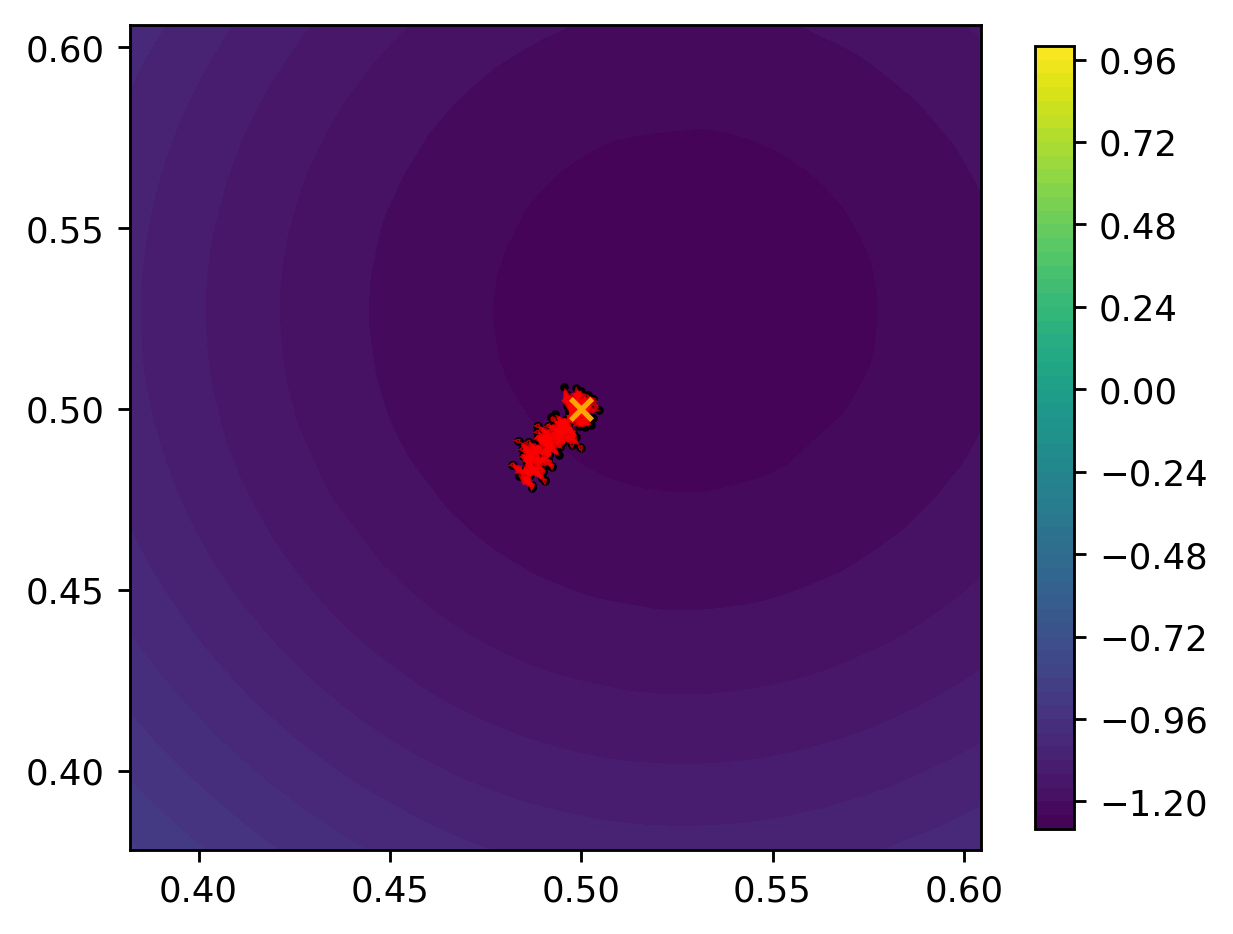

In [13]:
fig, ax = plt.subplots(figsize=(3.3*1.5,2.5*1.5),dpi=256)
cs = ax.tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax,shrink=0.95)
z = np.array(obj_func.history['z'])
ax.scatter(z[:,0],z[:,1],color='k',s=2)
for i in range(len(z) - 1):
    dx = z[i + 1, 0] - z[i, 0]
    dy = z[i + 1, 1] - z[i, 1]
    distance = np.sqrt(dx**2 + dy**2)
    # Scale arrowhead size based on the distance
    head_size = distance * 0.28  # Adjust 0.2 as a scaling factor if needed
    ax.arrow(z[i, 0]+0.2*dx, z[i, 1]+0.2*dy, 
              0.6*dx, 0.6*dy,
              color='r', alpha=0.7, 
              width = 0.02*head_size,
              head_width=0.8*head_size, 
              head_length=head_size, 
              length_includes_head=True)
ax.scatter(z[0,0],z[0,1],marker='x',color='orange')
ax.set_xlim(z[:,0].min()-0.1,z[:,0].max()+0.1);
ax.set_ylim(z[:,1].min()-0.1,z[:,1].max()+0.1);
fig.tight_layout()

In [14]:
obj_NM = obj_func

# Pure ES

In [15]:
obj_func = const_obj_func()
sv = savo(obj_func= obj_func,
          x0 = x0,
          max_dx = max_dx,
          x_bounds = x_bounds,
          )

In [16]:
sv.runES(budget)

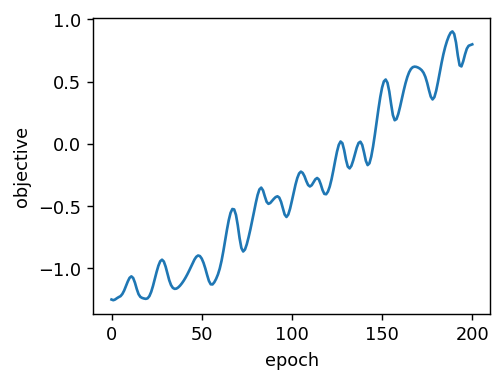

In [17]:
fig, ax = plt.subplots(figsize=(4,3),dpi=128)
ax.plot(obj_func.history['y']);
ax.set_xlabel('epoch');
ax.set_ylabel('objective');

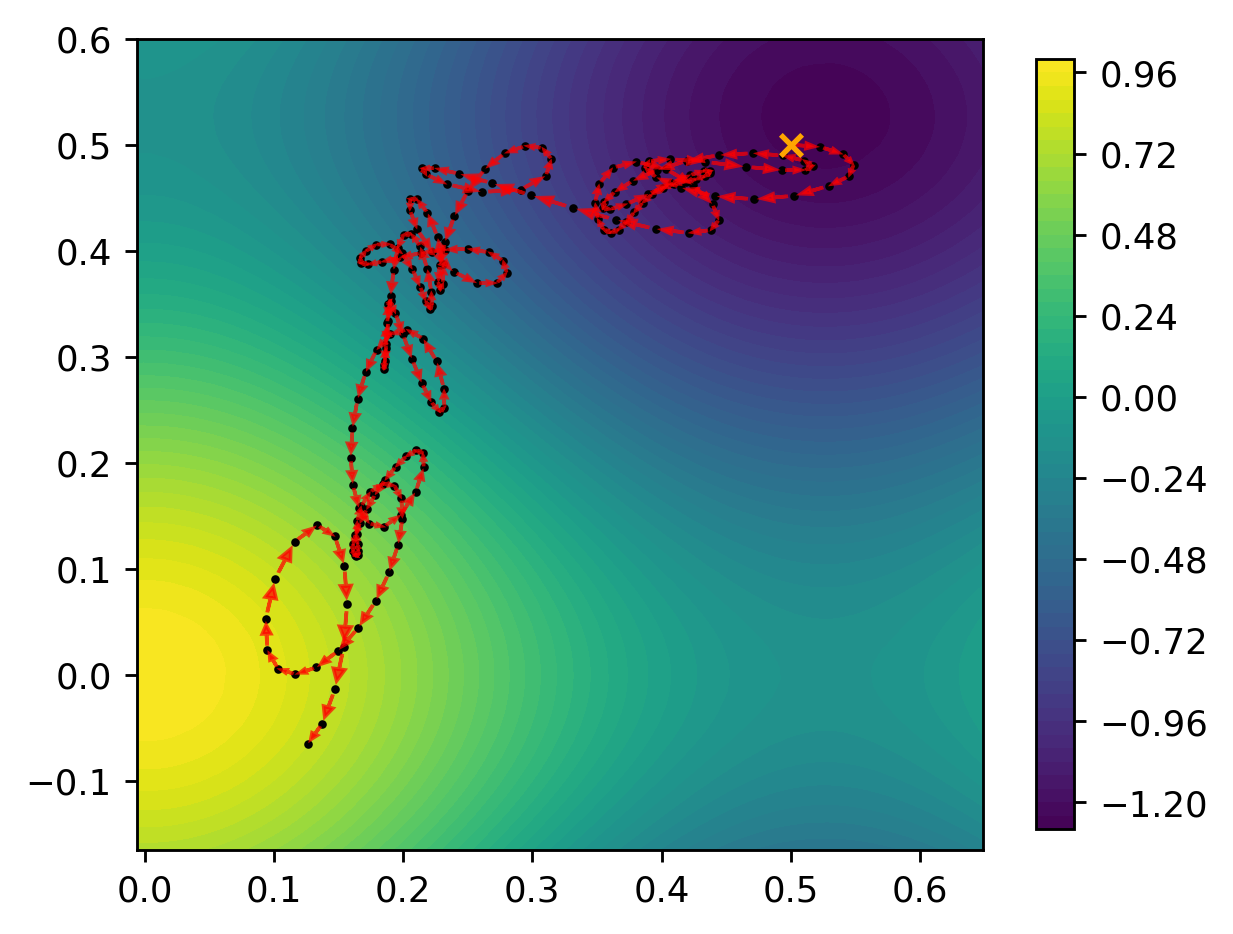

In [18]:
fig, ax = plt.subplots(figsize=(3.3*1.5,2.5*1.5),dpi=256)
cs = ax.tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax,shrink=0.95)
z = np.array(obj_func.history['z'])
ax.scatter(z[:,0],z[:,1],color='k',s=2)
for i in range(len(z) - 1):
    dx = z[i + 1, 0] - z[i, 0]
    dy = z[i + 1, 1] - z[i, 1]
    distance = np.sqrt(dx**2 + dy**2)
    # Scale arrowhead size based on the distance
    head_size = distance * 0.28  # Adjust 0.2 as a scaling factor if needed
    ax.arrow(z[i, 0]+0.2*dx, z[i, 1]+0.2*dy, 
              0.6*dx, 0.6*dy,
              color='r', alpha=0.7, 
              width = 0.02*head_size,
              head_width=0.8*head_size, 
              head_length=head_size, 
              length_includes_head=True)
ax.scatter(z[0,0],z[0,1],marker='x',color='orange')
ax.set_xlim(z[:,0].min()-0.1,z[:,0].max()+0.1);
ax.set_ylim(z[:,1].min()-0.1,z[:,1].max()+0.1);
fig.tight_layout()

In [19]:
obj_ES = obj_func

# SAVO

In [20]:
obj_func = const_obj_func()
sv = savo(obj_func= obj_func,
          x0 = x0,
          max_dx = max_dx,
          x_bounds = x_bounds,
          )

In [21]:
sv.runES(ninit)
sv.run_savo(budget-ninit,lambdaES=1,lr=lr)

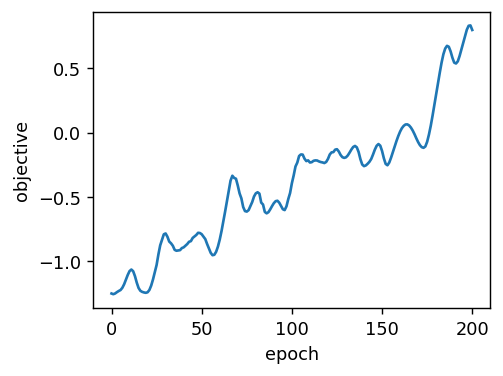

In [22]:
fig, ax = plt.subplots(figsize=(4,3),dpi=128)
ax.plot(obj_func.history['y']);
ax.set_xlabel('epoch');
ax.set_ylabel('objective');

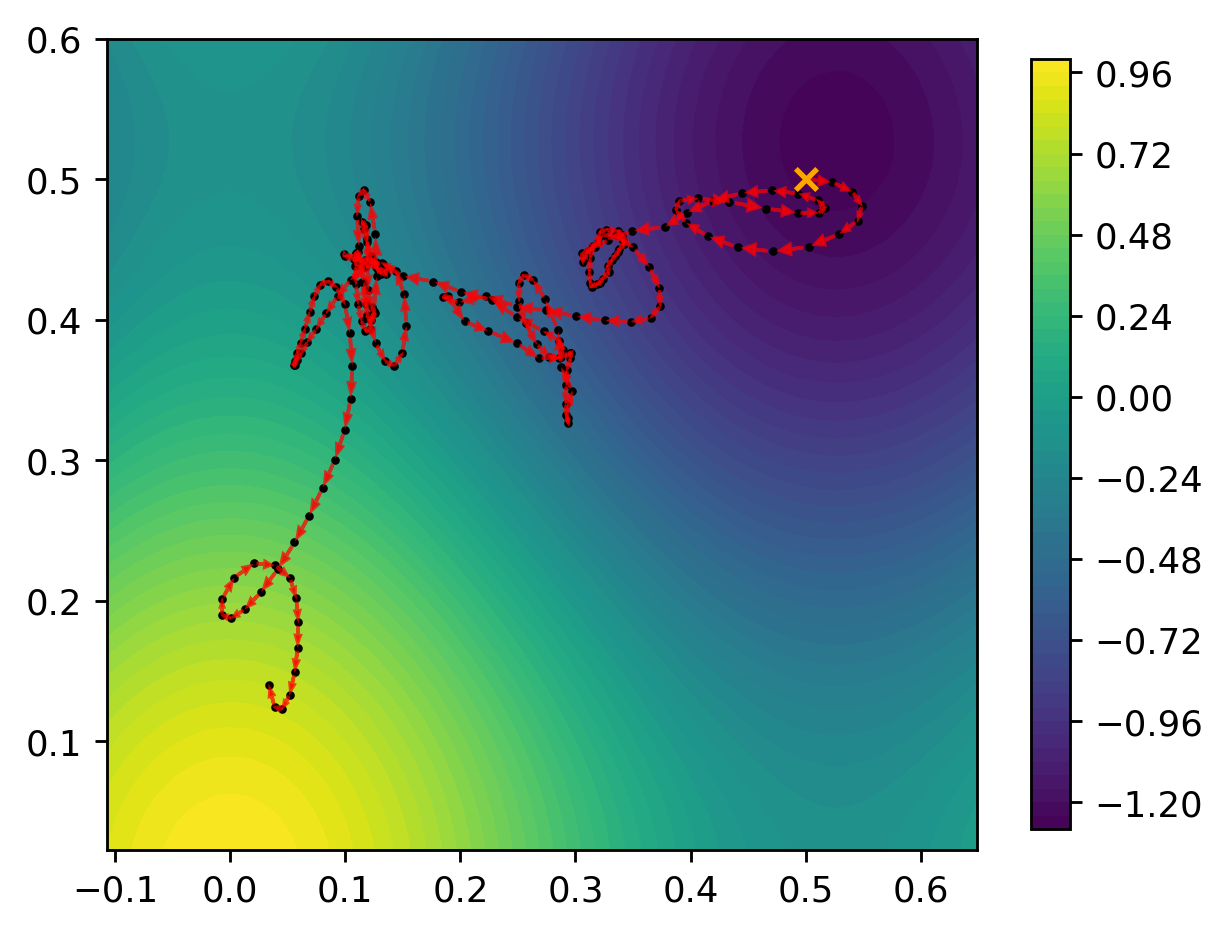

In [23]:
fig, ax = plt.subplots(figsize=(3.3*1.5,2.5*1.5),dpi=256)
cs = ax.tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax,shrink=0.95)
z = np.array(obj_func.history['z'])
ax.scatter(z[:,0],z[:,1],color='k',s=2)
for i in range(len(z) - 1):
    dx = z[i + 1, 0] - z[i, 0]
    dy = z[i + 1, 1] - z[i, 1]
    distance = np.sqrt(dx**2 + dy**2)
    # Scale arrowhead size based on the distance
    head_size = distance * 0.28  # Adjust 0.2 as a scaling factor if needed
    ax.arrow(z[i, 0]+0.2*dx, z[i, 1]+0.2*dy, 
              0.6*dx, 0.6*dy,
              color='r', alpha=0.7, 
              width = 0.02*head_size,
              head_width=0.8*head_size, 
              head_length=head_size, 
              length_includes_head=True)
ax.scatter(z[0,0],z[0,1],marker='x',color='orange')
ax.set_xlim(z[:,0].min()-0.1,z[:,0].max()+0.1);
ax.set_ylim(z[:,1].min()-0.1,z[:,1].max()+0.1);
fig.tight_layout()

In [24]:
obj_SAVO = obj_func

# SAVO with Adam

In [25]:
obj_func = const_obj_func()
sv = savo(obj_func= obj_func,
          x0 = x0,
          max_dx = max_dx,
          x_bounds = x_bounds,
          )

In [26]:
sv.runES(ninit)
sv.run_savo(budget-ninit,lambdaES=1,lr=lr,adam=True)

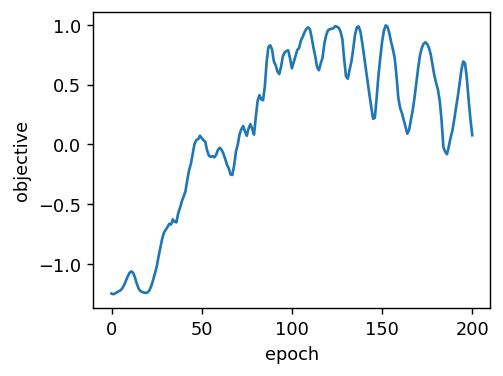

In [27]:
fig, ax = plt.subplots(figsize=(4,3),dpi=128)
ax.plot(obj_func.history['y']);
ax.set_xlabel('epoch');
ax.set_ylabel('objective');

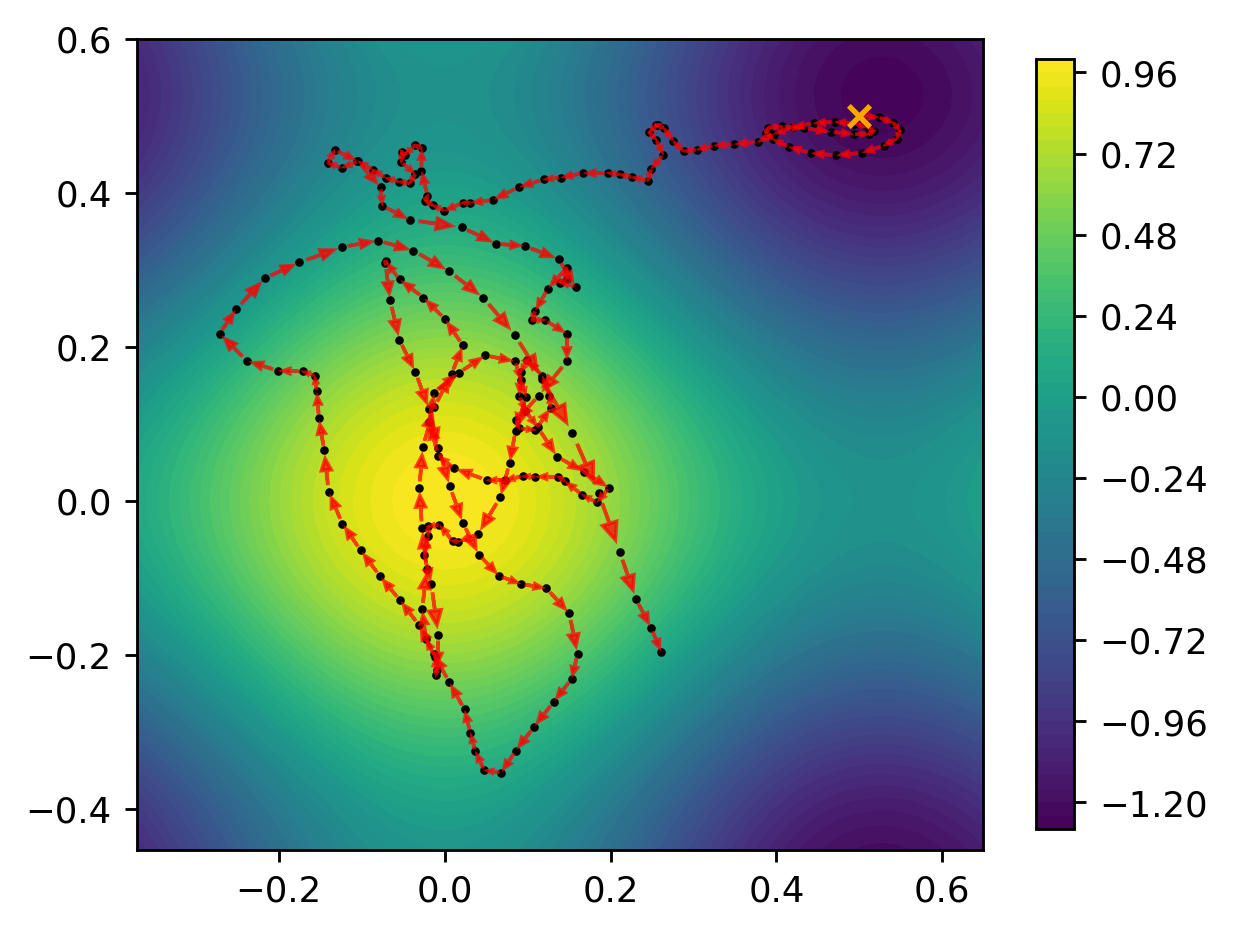

In [28]:
fig, ax = plt.subplots(figsize=(3.3*1.5,2.5*1.5),dpi=256)
cs = ax.tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax,shrink=0.95)
z = np.array(obj_func.history['z'])
ax.scatter(z[:,0],z[:,1],color='k',s=2)
for i in range(len(z) - 1):
    dx = z[i + 1, 0] - z[i, 0]
    dy = z[i + 1, 1] - z[i, 1]
    distance = np.sqrt(dx**2 + dy**2)
    # Scale arrowhead size based on the distance
    head_size = distance * 0.28  # Adjust 0.2 as a scaling factor if needed
    ax.arrow(z[i, 0]+0.2*dx, z[i, 1]+0.2*dy, 
              0.6*dx, 0.6*dy,
              color='r', alpha=0.7, 
              width = 0.02*head_size,
              head_width=0.8*head_size, 
              head_length=head_size, 
              length_includes_head=True)
ax.scatter(z[0,0],z[0,1],marker='x',color='orange')
ax.set_xlim(z[:,0].min()-0.1,z[:,0].max()+0.1);
ax.set_ylim(z[:,1].min()-0.1,z[:,1].max()+0.1);
fig.tight_layout()

In [29]:
obj_ADAM = obj_func

# SAVO without ES

In [30]:
obj_func = const_obj_func()
sv = savo(obj_func= obj_func,
          x0 = x0,
          max_dx = max_dx,
          x_bounds = x_bounds,
          )

In [31]:
sv.runES(ninit)
sv.run_savo(budget-ninit,lambdaES=0,lr=lr)

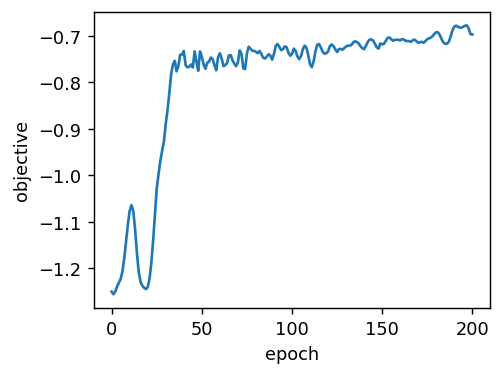

In [32]:
fig, ax = plt.subplots(figsize=(4,3),dpi=128)
ax.plot(obj_func.history['y']);
ax.set_xlabel('epoch');
ax.set_ylabel('objective');

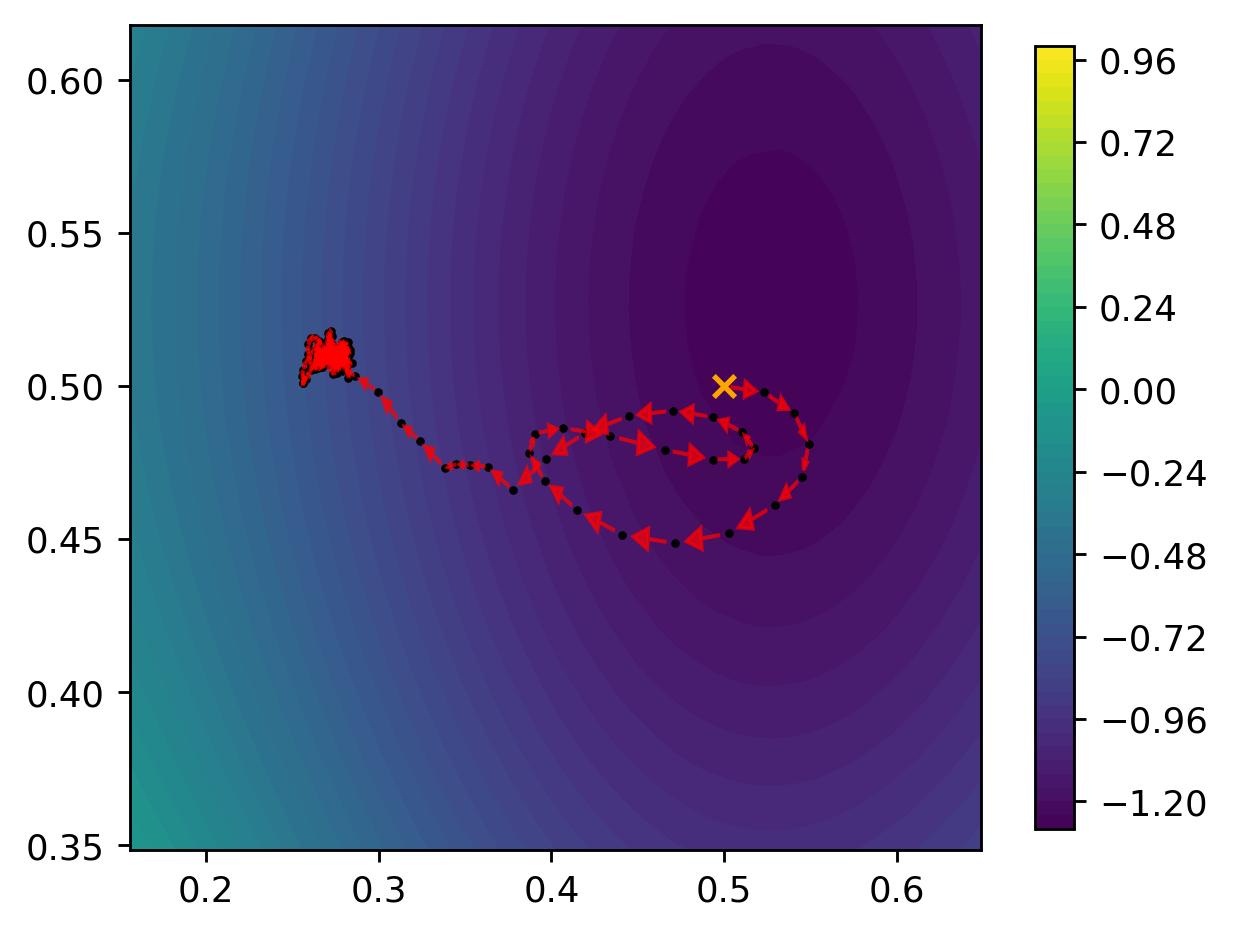

In [33]:
fig, ax = plt.subplots(figsize=(3.3*1.5,2.5*1.5),dpi=256)
cs = ax.tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax,shrink=0.95)
z = np.array(obj_func.history['z'])
ax.scatter(z[:,0],z[:,1],color='k',s=2)
for i in range(len(z) - 1):
    dx = z[i + 1, 0] - z[i, 0]
    dy = z[i + 1, 1] - z[i, 1]
    distance = np.sqrt(dx**2 + dy**2)
    # Scale arrowhead size based on the distance
    head_size = distance * 0.28  # Adjust 0.2 as a scaling factor if needed
    ax.arrow(z[i, 0]+0.2*dx, z[i, 1]+0.2*dy, 
              0.6*dx, 0.6*dy,
              color='r', alpha=0.7, 
              width = 0.02*head_size,
              head_width=0.8*head_size, 
              head_length=head_size, 
              length_includes_head=True)
ax.scatter(z[0,0],z[0,1],marker='x',color='orange')
ax.set_xlim(z[:,0].min()-0.1,z[:,0].max()+0.1);
ax.set_ylim(z[:,1].min()-0.1,z[:,1].max()+0.1);
fig.tight_layout()

In [34]:
obj_SAVO_noES = obj_func

# SAVO ADAM without ES

In [35]:
obj_func = const_obj_func()
sv = savo(obj_func= obj_func,
          x0 = x0,
          max_dx = max_dx,
          x_bounds = x_bounds,
          )

In [36]:
sv.runES(ninit)
sv.run_savo(budget-ninit,lambdaES=0,lr=lr,adam=True)

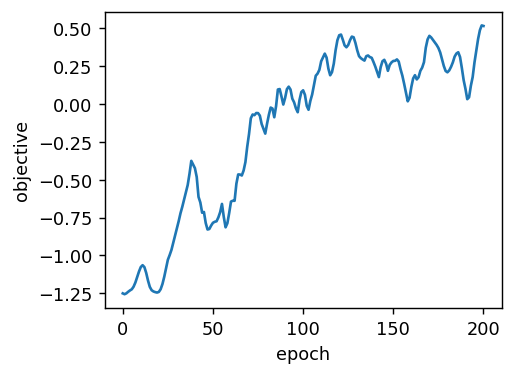

In [37]:
fig, ax = plt.subplots(figsize=(4,3),dpi=128)
ax.plot(obj_func.history['y']);
ax.set_xlabel('epoch');
ax.set_ylabel('objective');

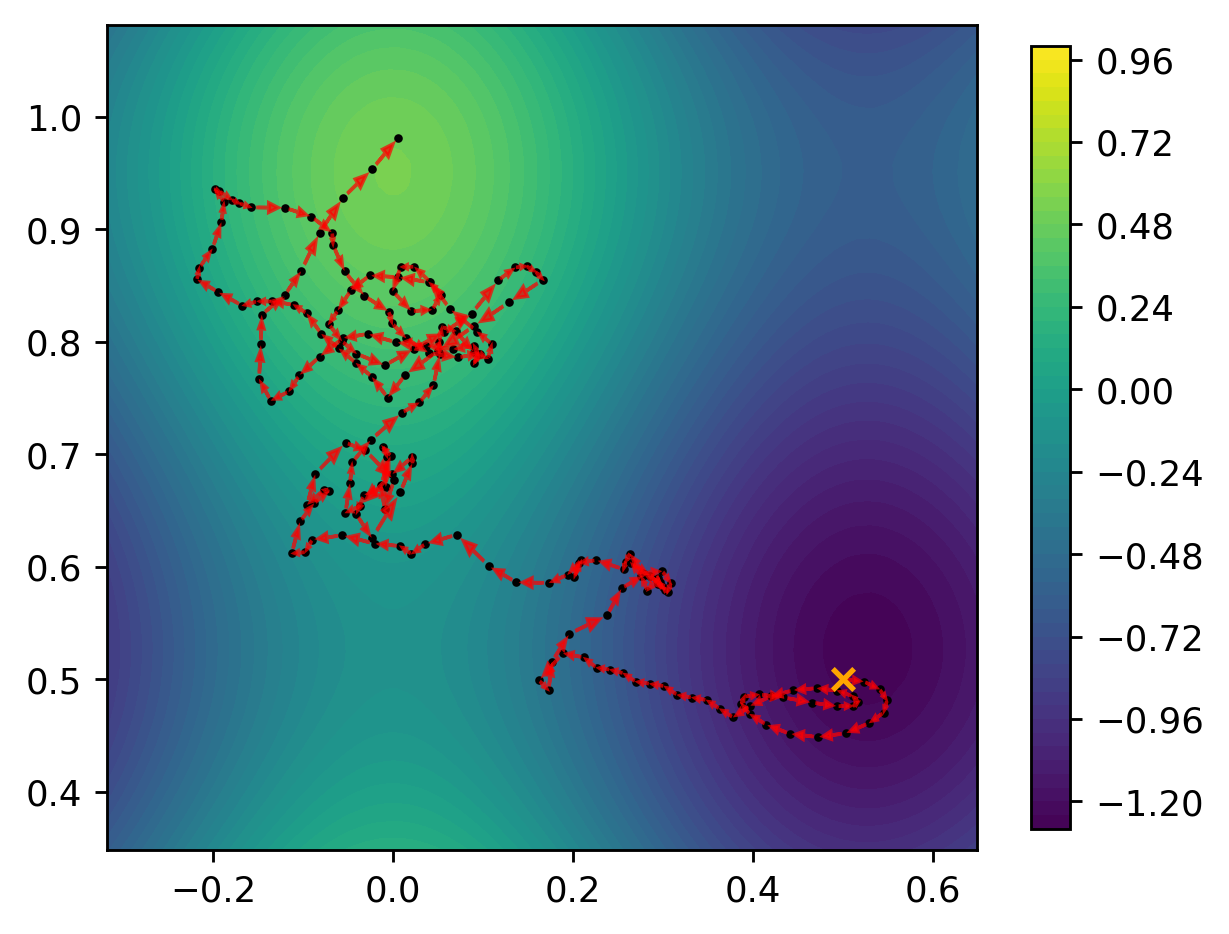

In [38]:
fig, ax = plt.subplots(figsize=(3.3*1.5,2.5*1.5),dpi=256)
cs = ax.tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax,shrink=0.95)
z = np.array(obj_func.history['z'])
ax.scatter(z[:,0],z[:,1],color='k',s=2)
for i in range(len(z) - 1):
    dx = z[i + 1, 0] - z[i, 0]
    dy = z[i + 1, 1] - z[i, 1]
    distance = np.sqrt(dx**2 + dy**2)
    # Scale arrowhead size based on the distance
    head_size = distance * 0.28  # Adjust 0.2 as a scaling factor if needed
    ax.arrow(z[i, 0]+0.2*dx, z[i, 1]+0.2*dy, 
              0.6*dx, 0.6*dy,
              color='r', alpha=0.7, 
              width = 0.02*head_size,
              head_width=0.8*head_size, 
              head_length=head_size, 
              length_includes_head=True)
ax.scatter(z[0,0],z[0,1],marker='x',color='orange')
ax.set_xlim(z[:,0].min()-0.1,z[:,0].max()+0.1);
ax.set_ylim(z[:,1].min()-0.1,z[:,1].max()+0.1);
fig.tight_layout()

In [39]:
obj_ADAM_noES = obj_func

# plot all

In [40]:
obj_funcs = [obj_NM, obj_ES, obj_SAVO, obj_ADAM, obj_SAVO_noES, obj_ADAM_noES]
obj_funcs_labels = ['Nelder-Mead', 'ES', 'ES+SG', 'ES+adamSG', 'SG', 'adamSG']

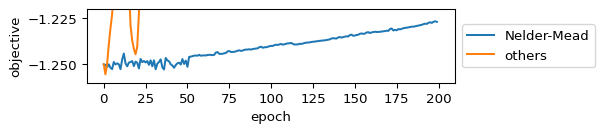

In [54]:
fig, ax = plt.subplots(figsize=(3.3*1.5,1),dpi=96)
i = 0
for obj_func, label in zip(obj_funcs,obj_funcs_labels) :
    if  i==1:
        break
    ax.plot(obj_func.history['y'],label=label);
    i+=1
ax.plot(obj_func.history['y'],label='others');
ax.set_xlabel('epoch');
ax.set_ylabel('objective');
ax.set_ylim(-1.26,-1.22)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

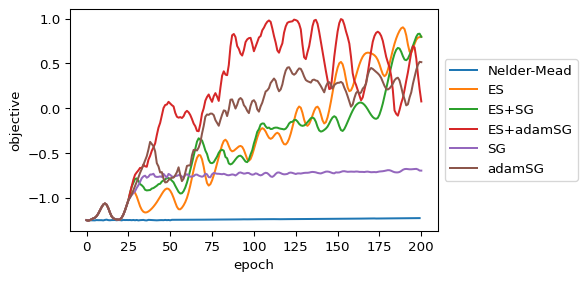

In [43]:
fig, ax = plt.subplots(figsize=(3.3*1.5,2*1.5),dpi=96)
for obj_func, label in zip(obj_funcs,obj_funcs_labels) :
    ax.plot(obj_func.history['y'],label=label);
ax.set_xlabel('epoch');
ax.set_ylabel('objective');
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))